Here is 👉 the Link [Google-Colab](https://colab.research.google.com/drive/1umiLFGqHScneGFjeTW3Bkk_agY1uhoJ1?authuser=1#scrollTo=X_Sv25w7Ouro)

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
#import matplotlib.pyplot as plt

# Download the Data through Kaggle API
from google.colab import files

In [3]:
# Using Kaggle API to Download the Dataset

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [4]:
# Download the Dataset
!kaggle datasets download -d defileroff/comic-faces-paired-synthetic-v2

100% 2.18G/2.18G [01:41<00:00, 20.7MB/s]
100% 2.18G/2.18G [01:41<00:00, 23.0MB/s]


In [5]:
# After Downloaded and Unzip the file through this code

In [6]:
from zipfile import ZipFile
file_name = "/content/comic-faces-paired-synthetic-v2.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')
  zip.extractall(path="/content")

Done


In [7]:
import glob,random,os,shutil

In [8]:
comics = glob.glob('/content/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/comics/**/*.jpg',recursive=True)
faces = glob.glob('/content/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/**/*.jpg',recursive=True)

random.shuffle(faces)
random.shuffle(comics)

train_perc = 0.8

os.makedirs('/content/real_comic_data/train/real')
os.makedirs('/content/real_comic_data/train/comic')
os.makedirs('/content/real_comic_data/val/real')
os.makedirs('/content/real_comic_data/val/comic')

for file in faces[:round(len(faces)*train_perc)]:
    shutil.copy(file,'/content/real_comic_data/train/real/')

for file in faces[round(len(faces)*train_perc):]:
    shutil.copy(file,'/content/real_comic_data/val/real/')

for file in comics[:round(len(comics)*train_perc)]:
    shutil.copy(file,'/content/real_comic_data/train/comic/')

for file in comics[round(len(comics)*train_perc):]:
    shutil.copy(file,'/content/real_comic_data/val/comic/')

In [9]:
# re-size all the images to this
IMAGE_SIZE = [640, 640]

train_path = '/content/real_comic_data/train/'
valid_path = '/content/real_comic_data/val/'

In [10]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 5s 0us/step


In [11]:
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

In [16]:
 # useful for getting number of output classes
folders = glob.glob('/content/real_comic_data/train/*')

In [17]:
folders

['/content/real_comic_data/train/real', '/content/real_comic_data/train/comic']

In [18]:
# our layers - you can add more if you want
x = Flatten()(inception.output)

In [19]:
prediction = Dense(len(folders), activation='sigmoid')(x)
# prediction.add(tf.keras.layers.Dense(10, activation = 'sigmoid'))

# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [20]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 319, 319, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 319, 319, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [21]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [22]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [23]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/real_comic_data/train/',
                                                 target_size = (640, 640),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 16000 images belonging to 2 classes.


In [24]:
test_set = test_datagen.flow_from_directory('/content/real_comic_data/val/',
                                            target_size = (640, 640),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 4000 images belonging to 2 classes.


In [ ]:
# fit the model
# Run the cell. It will take some time to execute
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=15,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


132/132 [==============================] - 2530s 19s/step - loss: 0.0493 - accuracy: 0.9938 - val_loss: 0.0561 - val_accuracy: 0.9988


In [ ]:
import matplotlib.pyplot as plt

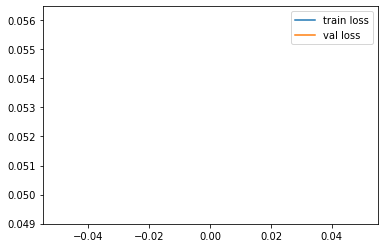

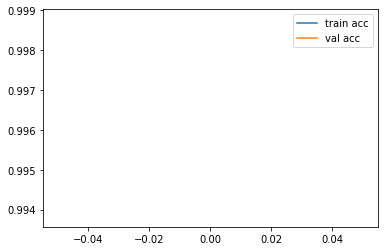

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
# save it as a h5 file

from tensorflow.keras.models import load_model

model.save('model_inception_2.h5')

In [ ]:
y_pred = model.predict(test_set)

26/26 [==============================] - 23s 825ms/step


In [ ]:
y_pred

array([[2.656844e-29, 1.000000e+00],
       [0.000000e+00, 1.000000e+00],
       [0.000000e+00, 1.000000e+00],
       ...,
       [0.000000e+00, 1.000000e+00],
       [0.000000e+00, 1.000000e+00],
       [0.000000e+00, 1.000000e+00]], dtype=float32)

In [ ]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
y_pred

array([1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [ ]:
model=load_model('model_inception_2.h5')


In [ ]:
real_face=image.load_img('/content/real_comic_data/val/real/1013.jpg',target_size=(640, 640))


In [ ]:
x=image.img_to_array(real_face)
x

array([[[221., 221., 221.],
        [221., 221., 221.],
        [221., 221., 221.],
        ...,
        [213., 213., 215.],
        [213., 213., 215.],
        [211., 212., 216.]],

       [[221., 221., 221.],
        [221., 221., 221.],
        [221., 221., 221.],
        ...,
        [213., 213., 215.],
        [213., 213., 215.],
        [212., 213., 217.]],

       [[221., 221., 221.],
        [221., 221., 221.],
        [221., 221., 221.],
        ...,
        [213., 213., 215.],
        [213., 213., 215.],
        [213., 214., 216.]],

       ...,

       [[ 19.,  23.,  34.],
        [ 18.,  22.,  33.],
        [ 17.,  21.,  32.],
        ...,
        [  5.,   6.,  10.],
        [  4.,   5.,   7.],
        [  6.,   6.,   8.]],

       [[ 21.,  25.,  36.],
        [ 20.,  24.,  35.],
        [ 19.,  23.,  34.],
        ...,
        [  5.,   6.,  10.],
        [  4.,   5.,   7.],
        [  6.,   6.,   8.]],

       [[ 22.,  26.,  37.],
        [ 21.,  25.,  36.],
        [ 20.,  

In [ ]:
x.shape

(640, 640, 3)

In [ ]:
x=x/255

In [ ]:
import numpy as np
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 640, 640, 3)

In [ ]:
model.predict(img_data)

1/1 [==============================] - 3s 3s/step


array([[1.0000000e+00, 1.3959039e-22]], dtype=float32)

In [ ]:
a=np.argmax(model.predict(img_data), axis=1)

1/1 [==============================] - 0s 36ms/step


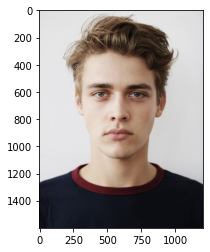

It's a Real Face


In [ ]:
# Just change the image "path" which was given by "real_face"

path = '/content/real_comic_data/val/real/1013.jpg'
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(path)
imgplot = plt.imshow(img)
if (a == 1):
  plt.show()
  print("It's a Comic Face")
else:
  plt.show()
  print("It's a Real Face")

In [ ]:
if (a==1):
  print("It's a Comic Face")
else:
  print("It's a Real Face")

It's a Real Face


In [ ]:
# Now test the Comic Faces

In [ ]:
comic_face=image.load_img('/content/real_comic_data/val/comic/101.jpg',target_size=(640, 640))

In [ ]:
x=image.img_to_array(comic_face)
x

array([[[ 90.,  97., 105.],
        [ 71.,  78.,  86.],
        [ 58.,  65.,  73.],
        ...,
        [ 63.,  73.,  82.],
        [ 67.,  77.,  86.],
        [ 78.,  88.,  97.]],

       [[ 59.,  66.,  74.],
        [ 55.,  62.,  70.],
        [ 54.,  61.,  69.],
        ...,
        [ 51.,  61.,  70.],
        [ 54.,  64.,  73.],
        [ 62.,  72.,  81.]],

       [[ 60.,  67.,  75.],
        [ 54.,  61.,  69.],
        [ 54.,  61.,  69.],
        ...,
        [ 53.,  63.,  72.],
        [ 54.,  64.,  73.],
        [ 59.,  69.,  78.]],

       ...,

       [[  8.,  10.,   9.],
        [ 18.,  20.,  19.],
        [ 18.,  20.,  19.],
        ...,
        [ 56.,  59.,  68.],
        [ 54.,  57.,  66.],
        [ 67.,  70.,  79.]],

       [[  9.,  11.,  10.],
        [ 12.,  14.,  13.],
        [ 14.,  16.,  15.],
        ...,
        [ 51.,  54.,  63.],
        [ 51.,  54.,  63.],
        [ 71.,  74.,  83.]],

       [[ 38.,  40.,  39.],
        [ 14.,  16.,  15.],
        [ 11.,  

In [ ]:
x=image.img_to_array(comic_face)
x

array([[[ 90.,  97., 105.],
        [ 71.,  78.,  86.],
        [ 58.,  65.,  73.],
        ...,
        [ 63.,  73.,  82.],
        [ 67.,  77.,  86.],
        [ 78.,  88.,  97.]],

       [[ 59.,  66.,  74.],
        [ 55.,  62.,  70.],
        [ 54.,  61.,  69.],
        ...,
        [ 51.,  61.,  70.],
        [ 54.,  64.,  73.],
        [ 62.,  72.,  81.]],

       [[ 60.,  67.,  75.],
        [ 54.,  61.,  69.],
        [ 54.,  61.,  69.],
        ...,
        [ 53.,  63.,  72.],
        [ 54.,  64.,  73.],
        [ 59.,  69.,  78.]],

       ...,

       [[  8.,  10.,   9.],
        [ 18.,  20.,  19.],
        [ 18.,  20.,  19.],
        ...,
        [ 56.,  59.,  68.],
        [ 54.,  57.,  66.],
        [ 67.,  70.,  79.]],

       [[  9.,  11.,  10.],
        [ 12.,  14.,  13.],
        [ 14.,  16.,  15.],
        ...,
        [ 51.,  54.,  63.],
        [ 51.,  54.,  63.],
        [ 71.,  74.,  83.]],

       [[ 38.,  40.,  39.],
        [ 14.,  16.,  15.],
        [ 11.,  

In [ ]:
x=x/255

In [ ]:
import numpy as np
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 640, 640, 3)

In [ ]:
model.predict(img_data)

1/1 [==============================] - 0s 30ms/step


array([[1.0000000e+00, 1.0540354e-18]], dtype=float32)

In [ ]:
a=np.argmax(model.predict(img_data), axis=1)

1/1 [==============================] - 0s 28ms/step


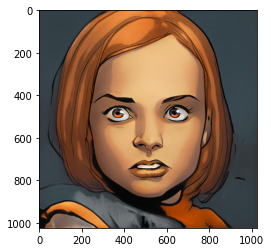

It's a Comic Face


In [ ]:
# Just change the image "path" which was given by "comic_face"

path = '/content/real_comic_data/val/comic/104.jpg'
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(path)
imgplot = plt.imshow(img)
if (a == 1):
  plt.show()
  print("It's a Real Face")
else:
  plt.show()
  print("It's a Comic Face")

In [ ]:
if (a==1):
  print("It's a Real Face")
else:
  print("It's a Comic Face")

It's a Comic Face


This Classification model is working well since we load the image from Real Face data folder this model classified perfecftly